# Sub Quesiton 1

In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_25_26 = pd.read_csv(r"C:\Users\Thitirat\Downloads\Quantitative - Copy of 25-26 Season.csv")
df_24_25 = pd.read_csv(r"C:\Users\Thitirat\Downloads\Quantitative - Copy of 24-25 Season (1).csv")


In [3]:
df_25_26['Season'] = '2025–26'
df_24_25['Season'] = '2024–25'


In [4]:

df_combined = pd.concat([df_24_25, df_25_26], ignore_index=True)


In [5]:
df_combined.head()

,Set,Opponent,Timestamp,Rally,Rotation,Stage,Player,Action Type,Action,Assist,Point To,Score,Timeout_called,Sideout,Runs,Runs_Before,Season
0,1,MUIDS,3:29:50 PM,1.0,2.0,serve,#11 Alisa,earned,Ace,-,us,1 -- 0,0,1,0,0,2024–25
1,1,MUIDS,3:30:33 PM,2.0,2.0,serve,#5 Aom,errors,Spike,#1 - Hrishika,them,1 -- 1,0,0,1,0,2024–25
2,1,MUIDS,3:30:58 PM,3.0,2.0,receive,#5 Aom,earned,Spike,#1 - Hrishika,us,2 -- 1,0,1,0,1,2024–25
3,1,MUIDS,3:31:22 PM,4.0,3.0,serve,#1 Hrishika,errors,Serve,-,them,2 -- 2,0,0,1,0,2024–25
4,1,MUIDS,3:31:42 PM,5.0,3.0,receive,#5 Aom,earned,Spike,#1 - Hrishika,us,3 -- 2,0,1,0,1,2024–25


In [6]:

def analyze_run_length_effect_on_sideout(df):
    # 1. Drop missing values in key columns
    df = df.dropna(subset=['Sideout', 'Runs_Before'])

    # 2. Convert types
    df['Sideout'] = pd.to_numeric(df['Sideout'], errors='coerce').astype(int)
    df['Runs_Before'] = pd.to_numeric(df['Runs_Before'], errors='coerce')

    # 3. Create run length bins
    def categorize_run(run):
        if run <= 2:
            return '0–2'
        elif run <= 4:
            return '3–4'
        elif run <= 6:
            return '5–6'
        else:
            return '7+'

    df['Run_Category'] = df['Runs_Before'].apply(categorize_run)
    # 4. Create dummy variables
    dummies = pd.get_dummies(df['Run_Category'], prefix='Run_Category')
    df_model = pd.concat([df, dummies], axis=1)

    # Ensure all expected bins exist
    for col in ['Run_Category_3–4', 'Run_Category_5–6', 'Run_Category_7+']:
        if col not in df_model.columns:
            df_model[col] = 0

    # 5. Build logistic regression model
    df_model['Intercept'] = 1
    X = df_model[['Intercept', 'Run_Category_3–4', 'Run_Category_5–6', 'Run_Category_7+']].astype(float)
    y = df_model['Sideout'].astype(float)

    model = sm.GLM(y, X, family=sm.families.Binomial())
    result = model.fit()
    print(result.summary())

    # 6. Visualize side-out rate by run length
    grouped = df.groupby('Run_Category')['Sideout'].mean().reindex(['0–2', '3–4', '5–6', '7+'])

    ax = grouped.plot(kind='bar', color='#4c72b0', figsize=(7, 4))
    plt.title('Side-out Percentage by Opponent Run Length')
    plt.xlabel('Run Length Category')
    plt.ylabel('Side-out Rate')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    for i, rate in enumerate(grouped):
        plt.text(i, rate + 0.02, f'{rate:.1%}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Sideout   No. Observations:                 5878
Model:                            GLM   Df Residuals:                     5874
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4060.2
Date:                Mon, 24 Nov 2025   Deviance:                       8120.5
Time:                        12:17:43   Pearson chi2:                 5.88e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.003123
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1233      0.028  

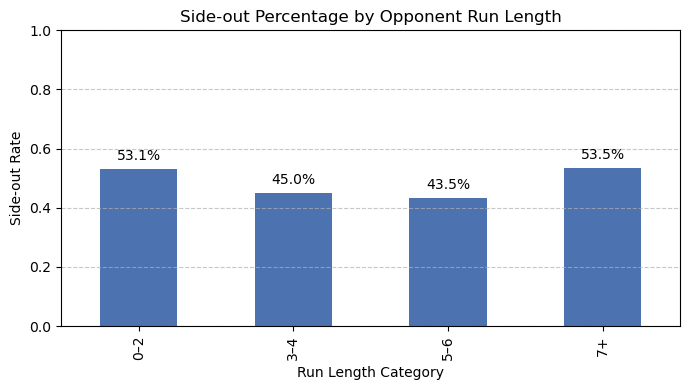

In [7]:
analyze_run_length_effect_on_sideout(df_combined)

In [9]:
df = df_combined.dropna(subset=['Sideout', 'Runs_Before'])

# 2. Ensure correct types
df['Sideout'] = pd.to_numeric(df['Sideout'], errors='coerce')
df = df[df['Sideout'].isin([0, 1])]
df['Runs_Before'] = pd.to_numeric(df['Runs_Before'], errors='coerce')

# 3. Build model matrix
X = sm.add_constant(df['Runs_Before'])  # Adds intercept
y = df['Sideout'].astype(float)

# 4. Fit logistic regression
model = sm.GLM(y, X, family=sm.families.Binomial())
result = model.fit()

# 5. Output results
print(result.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                Sideout   No. Observations:                 5878
Model:                            GLM   Df Residuals:                     5876
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4057.8
Date:                Mon, 24 Nov 2025   Deviance:                       8115.6
Time:                        12:25:45   Pearson chi2:                 5.88e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.003946
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1665      0.032      5.278      

In [10]:
## PROBABILITY TABLE
# Coefficients from your model
intercept = 0.1665
slope = -0.0827

# Logistic function
def logistic(x):
    return 1 / (1 + np.exp(-x))

# Create a range of run lengths (e.g., 0 to 10)
run_lengths = list(range(0, 11))
log_odds = [intercept + slope * r for r in run_lengths]
probabilities = [logistic(lo) for lo in log_odds]

# Create table
df_probs = pd.DataFrame({
    'Opponent Run Length': run_lengths,
    'Predicted Side-out Probability': [f'{p:.1%}' for p in probabilities]
})

print(df_probs)


    Opponent Run Length Predicted Side-out Probability
0                     0                          54.2%
1                     1                          52.1%
2                     2                          50.0%
3                     3                          48.0%
4                     4                          45.9%
5                     5                          43.9%
6                     6                          41.8%
7                     7                          39.8%
8                     8                          37.9%
9                     9                          35.9%
10                   10                          34.1%


# Sub Question 2 

In [12]:
def categorize_run(r):
    if r <= 2:
        return '0–2'
    elif r <= 4:
        return '3–4'
    elif r <= 6:
        return '5–6'
    else:
        return '7+'

df_combined['Run_Category'] = df_combined['Runs_Before'].apply(categorize_run)

# Calculate side-out rate by run category
sideout_summary = df_combined.groupby('Run_Category')['Sideout'].agg(['sum', 'count'])
sideout_summary['sideout_rate'] = sideout_summary['sum'] / sideout_summary['count']
print(sideout_summary[['sideout_rate']])


              sideout_rate
Run_Category              
0–2               0.530789
3–4               0.450000
5–6               0.434783
7+                0.535211


In [13]:
def categorize_run(run):
    if run <= 2:
        return '0–2'
    elif run <= 4:
        return '3–4'
    elif run <= 6:
        return '5–6'
    else:
        return '7+'

df_combined['Run_Category'] = df_combined['Runs_Before'].apply(categorize_run)

# 2. Normalize action type
df_combined['Action Type'] = df_combined['Action Type'].str.strip().str.lower()

# 3. Group and calculate proportions
composition = (
    df_combined.groupby(['Run_Category', 'Action Type'])
    .size()
    .unstack(fill_value=0)
)

# 4. Convert to percentages
composition_percent = composition.div(composition.sum(axis=1), axis=0) * 100
print(composition_percent)


Action Type      earned     errors    faults  in_rally   timeout
Run_Category                                                    
0–2           55.136310  41.781904  2.489135  0.019755  0.572896
3–4           50.000000  45.925926  3.148148  0.000000  0.925926
5–6           49.456522  46.195652  2.173913  0.000000  2.173913
7+            53.521127  39.436620  2.816901  0.000000  4.225352


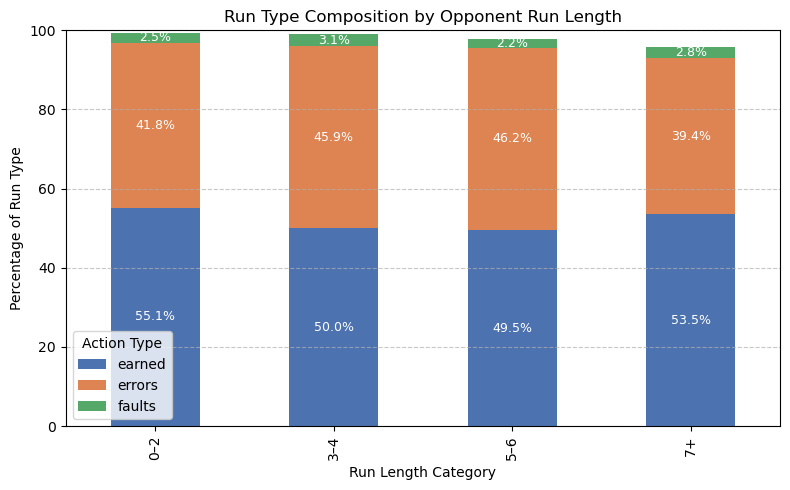

In [14]:
# 1. Data
data = {
    'Run_Category': ['0–2', '3–4', '5–6', '7+'],
    'earned': [55.136310, 50.000000, 49.456522 , 53.521127],
    'errors': [41.781904, 45.925926 , 46.195652, 39.436620],
    'faults': [2.489135, 3.148148, 2.173913, 2.816901]
}
df = pd.DataFrame(data)
df.set_index('Run_Category', inplace=True)

# 2. Plot
ax = df.plot(kind='bar', stacked=True, figsize=(8, 5), color=['#4c72b0', '#dd8452', '#55a868'])
plt.title('Run Type Composition by Opponent Run Length')
plt.xlabel('Run Length Category')
plt.ylabel('Percentage of Run Type')
plt.ylim(0, 100)
plt.legend(title='Action Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 3. Add percentage labels inside each segment
for i, row in enumerate(df.itertuples(index=False)):
    bottom = 0
    for val, color in zip(row, ['#4c72b0', '#dd8452', '#55a868']):
        plt.text(i, bottom + val / 2, f'{val:.1f}%', ha='center', va='center', color='white', fontsize=9)
        bottom += val

plt.tight_layout()
plt.show()


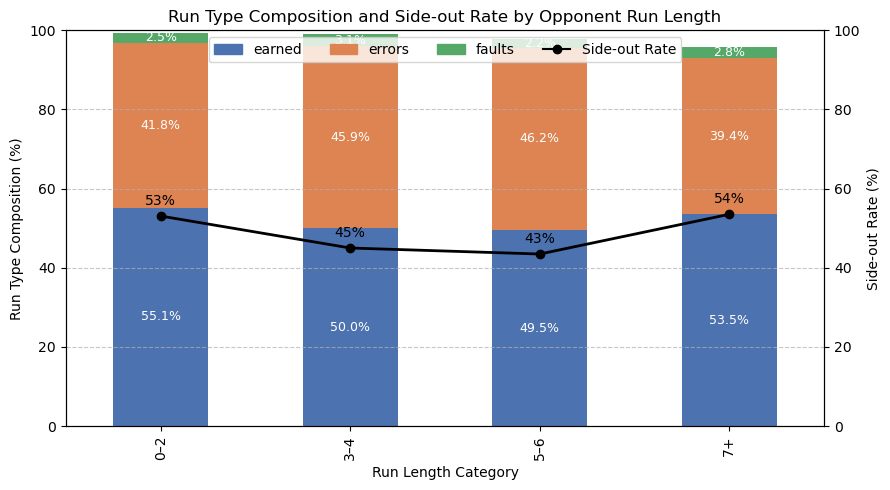

In [15]:
# combined

data = {
    'Run_Category': ['0–2', '3–4', '5–6', '7+'],
    'earned': [55.136310, 50.000000, 49.456522 , 53.521127],
    'errors': [41.781904, 45.925926 , 46.195652, 39.436620],
    'faults': [2.489135, 3.148148, 2.173913, 2.816901],
    'sideout_rate': [0.530789, 0.450000, 0.434783, 0.535211]
}
df = pd.DataFrame(data)
df.set_index('Run_Category', inplace=True)

# 2. Plot setup
fig, ax1 = plt.subplots(figsize=(9, 5))

# 3. Stacked bar chart for run type composition
colors = ['#4c72b0', '#dd8452', '#55a868']
df[['earned', 'errors', 'faults']].plot(kind='bar', stacked=True, ax=ax1, color=colors)
ax1.set_ylabel('Run Type Composition (%)')
ax1.set_ylim(0, 100)
ax1.set_xlabel('Run Length Category')
ax1.set_title('Run Type Composition and Side-out Rate by Opponent Run Length')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 4. Add side-out rate line on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(df.index, df['sideout_rate'] * 100, color='black', marker='o', linewidth=2, label='Side-out Rate')
ax2.set_ylabel('Side-out Rate (%)')
ax2.set_ylim(0, 100)

#5. Add percentage labels inside each bar segment
for i, row in enumerate(df.itertuples(index=False)):
    bottom = 0
    for val, color in zip(row[:3], colors):
        ax1.text(i, bottom + val / 2, f'{val:.1f}%', ha='center', va='center', color='white', fontsize=9)
        bottom += val

# 6. Add side-out rate labels
for i, val in enumerate(df['sideout_rate']):
    ax2.text(i, val * 100 + 2, f'{val:.0%}', ha='center', va='bottom', color='black', fontsize=10)

# 7. Legends
bars_labels = ['earned', 'errors', 'faults']
bar_handles = [plt.Rectangle((0,0),1,1,color=c) for c in colors]
line_handle = plt.Line2D([], [], color='black', marker='o', label='Side-out Rate')
ax1.legend(bar_handles + [line_handle], bars_labels + ['Side-out Rate'], loc='upper center', ncol=4)

plt.tight_layout()
plt.show()


In [18]:

# 2. Clean and prepare data
df_combined = df_combined.dropna(subset=['Sideout', 'Action Type'])
df_combined['Sideout'] = pd.to_numeric(df_combined['Sideout'], errors='coerce')
df_combined = df_combined[df_combined['Sideout'].isin([0, 1])]

# 3. Create dummy variables for Action Type
# Assuming categories: 'earned', 'errors', 'faults'
df_combined['Action Type'] = df_combined['Action Type'].astype(str).str.strip().str.lower()
dummies = pd.get_dummies(df_combined['Action Type'], prefix='Action')

# Drop 'earned' to use as baseline
if 'Action_earned' in dummies.columns:
    dummies = dummies.drop(columns='Action_earned')

# 4. Build model matrix
X = sm.add_constant(dummies.astype(float))
y = df_combined['Sideout'].astype(float)

# 5. Fit logistic regression
model = sm.GLM(y, X, family=sm.families.Binomial())
result = model.fit()

# 6. Output results
print(result.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                Sideout   No. Observations:                 5857
Model:                            GLM   Df Residuals:                     5852
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3880.1
Date:                Mon, 24 Nov 2025   Deviance:                       7760.1
Time:                        12:36:14   Pearson chi2:                 5.86e+03
No. Iterations:                    19   Pseudo R-squ. (CS):            0.05765
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5380      0.037     

In [19]:
# 1. Coefficients from your model
intercept = 0.5380
coef_errors = -0.9576
coef_faults = -1.0453
    
# 2. Compute log-odds and convert to probabilities
def logistic(x):
    return 1 / (1 + np.exp(-x))

log_odds = {
    'earned': intercept,
    'errors': intercept + coef_errors,
    'faults': intercept + coef_faults
}

probabilities = {k: logistic(v) for k, v in log_odds.items()}

# 3. Create and display table
df_probs = pd.DataFrame({
    'Point Type': list(probabilities.keys()),
    'Predicted Side-out Probability': [f"{p:.1%}" for p in probabilities.values()]
})

print(df_probs)


  Point Type Predicted Side-out Probability
0     earned                          63.1%
1     errors                          39.7%
2     faults                          37.6%


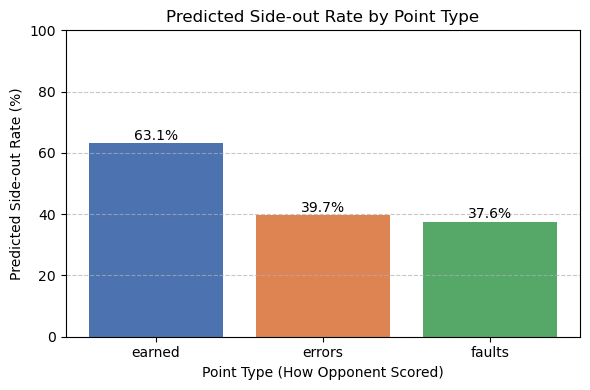

In [20]:

probs = {
    'earned': 0.631,
    'errors': 0.397,
    'faults': 0.376
}

# Bar chart setup
point_types = list(probs.keys())
values = [probs[pt] * 100 for pt in point_types]  # convert to percentages
colors = ['#4c72b0', '#dd8452', '#55a868']

plt.figure(figsize=(6, 4))
bars = plt.bar(point_types, values, color=colors)

# Add percentage labels on top
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, val + 1, f'{val:.1f}%', ha='center', fontsize=10)

plt.ylim(0, 100)
plt.title('Predicted Side-out Rate by Point Type')
plt.xlabel('Point Type (How Opponent Scored)')
plt.ylabel('Predicted Side-out Rate (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
